In [6]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [29]:
# Load data
npy_arrays='./salmonella_kmc7_arrays'
labels='./salmonella_subspecies_labels.tsv'

!head $labels
!ls $npy_arrays | head

GCA_000709535.1_ASM70953v1_genomic	Salmonella_bongori
GCA_000252995.1_ASM25299v1_genomic	Salmonella_bongori
GCA_000439255.1_ASM43925v1_genomic	Salmonella_bongori
GCA_002035285.1_ASM203528v1_genomic	Salmonella_bongori
GCA_002119365.1_ASM211936v1_genomic	Salmonella_bongori
GCA_002033765.1_ASM203376v1_genomic	Salmonella_bongori
GCA_002035265.1_ASM203526v1_genomic	Salmonella_bongori
GCA_002035315.1_ASM203531v1_genomic	Salmonella_bongori
GCA_002037625.1_ASM203762v1_genomic	Salmonella_bongori
GCA_002211925.1_ASM221192v1_genomic	Salmonella_bongori
GCA_000006945.2_ASM694v2_genomic_k7_k7.npy
GCA_000007545.1_ASM754v1_genomic_k7_k7.npy
GCA_000008105.1_ASM810v1_genomic_k7_k7.npy
GCA_000009505.1_ASM950v1_genomic_k7_k7.npy
GCA_000009525.1_ASM952v1_genomic_k7_k7.npy
GCA_000011885.1_ASM1188v1_genomic_k7_k7.npy
GCA_000016045.1_ASM1604v1_genomic_k7_k7.npy
GCA_000018385.1_ASM1838v1_genomic_k7_k7.npy
GCA_000018625.1_ASM1862v1_genomic_k7_k7.npy
GCA_000018705.1_ASM1870v1_genomic_k7_k7.npy
ls: write error: B

In [22]:
# Load labels
labels_df = pd.read_csv(labels, sep="\t", header=None, names=["prefix", "subspecies"])

# Remove unlabeled samples
labels_df = labels_df[labels_df["subspecies"] != "-"]

# Randomly subsample up to 200 per subspecies
labels_subsampled = (
    labels_df.groupby("subspecies", group_keys=False)
    .apply(lambda x: x.sample(n=min(500, len(x)), random_state=42))
    .reset_index(drop=True)
)

print(f"Selected {len(labels_subsampled)} total genomes across {labels_subsampled['subspecies'].nunique()} subspecies")

Selected 2684 total genomes across 7 subspecies


/tmp/ipykernel_1418785/889704756.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  labels_df.groupby("subspecies", group_keys=False)


In [23]:
# Load arrays
data_list, label_list = [], []

for i, row in labels_subsampled.iterrows():
    prefix = row["prefix"]
    subspecies = row["subspecies"]
    npy_filename = f"{prefix}_k7_k7.npy"
    npy_path = os.path.join(npy_arrays, npy_filename)
    
    if not os.path.exists(npy_path):
        print(f"! Missing file: {npy_filename}")
        continue
    
    arr = np.load(npy_path)
    data_list.append(arr.flatten())  # Flatten 2D FCGR
    label_list.append(subspecies)


In [24]:
# Stack into a matrix
X = np.vstack(data_list)
y = np.array(label_list)

print(f"Loaded {X.shape[0]} samples with {X.shape[1]} features.")

Loaded 2684 samples with 16384 features.


In [25]:
# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

explained_var = pca.explained_variance_ratio_ * 100
print(f"Explained variance: PC1={explained_var[0]:.2f}%, PC2={explained_var[1]:.2f}%")

Explained variance: PC1=69.01%, PC2=15.54%


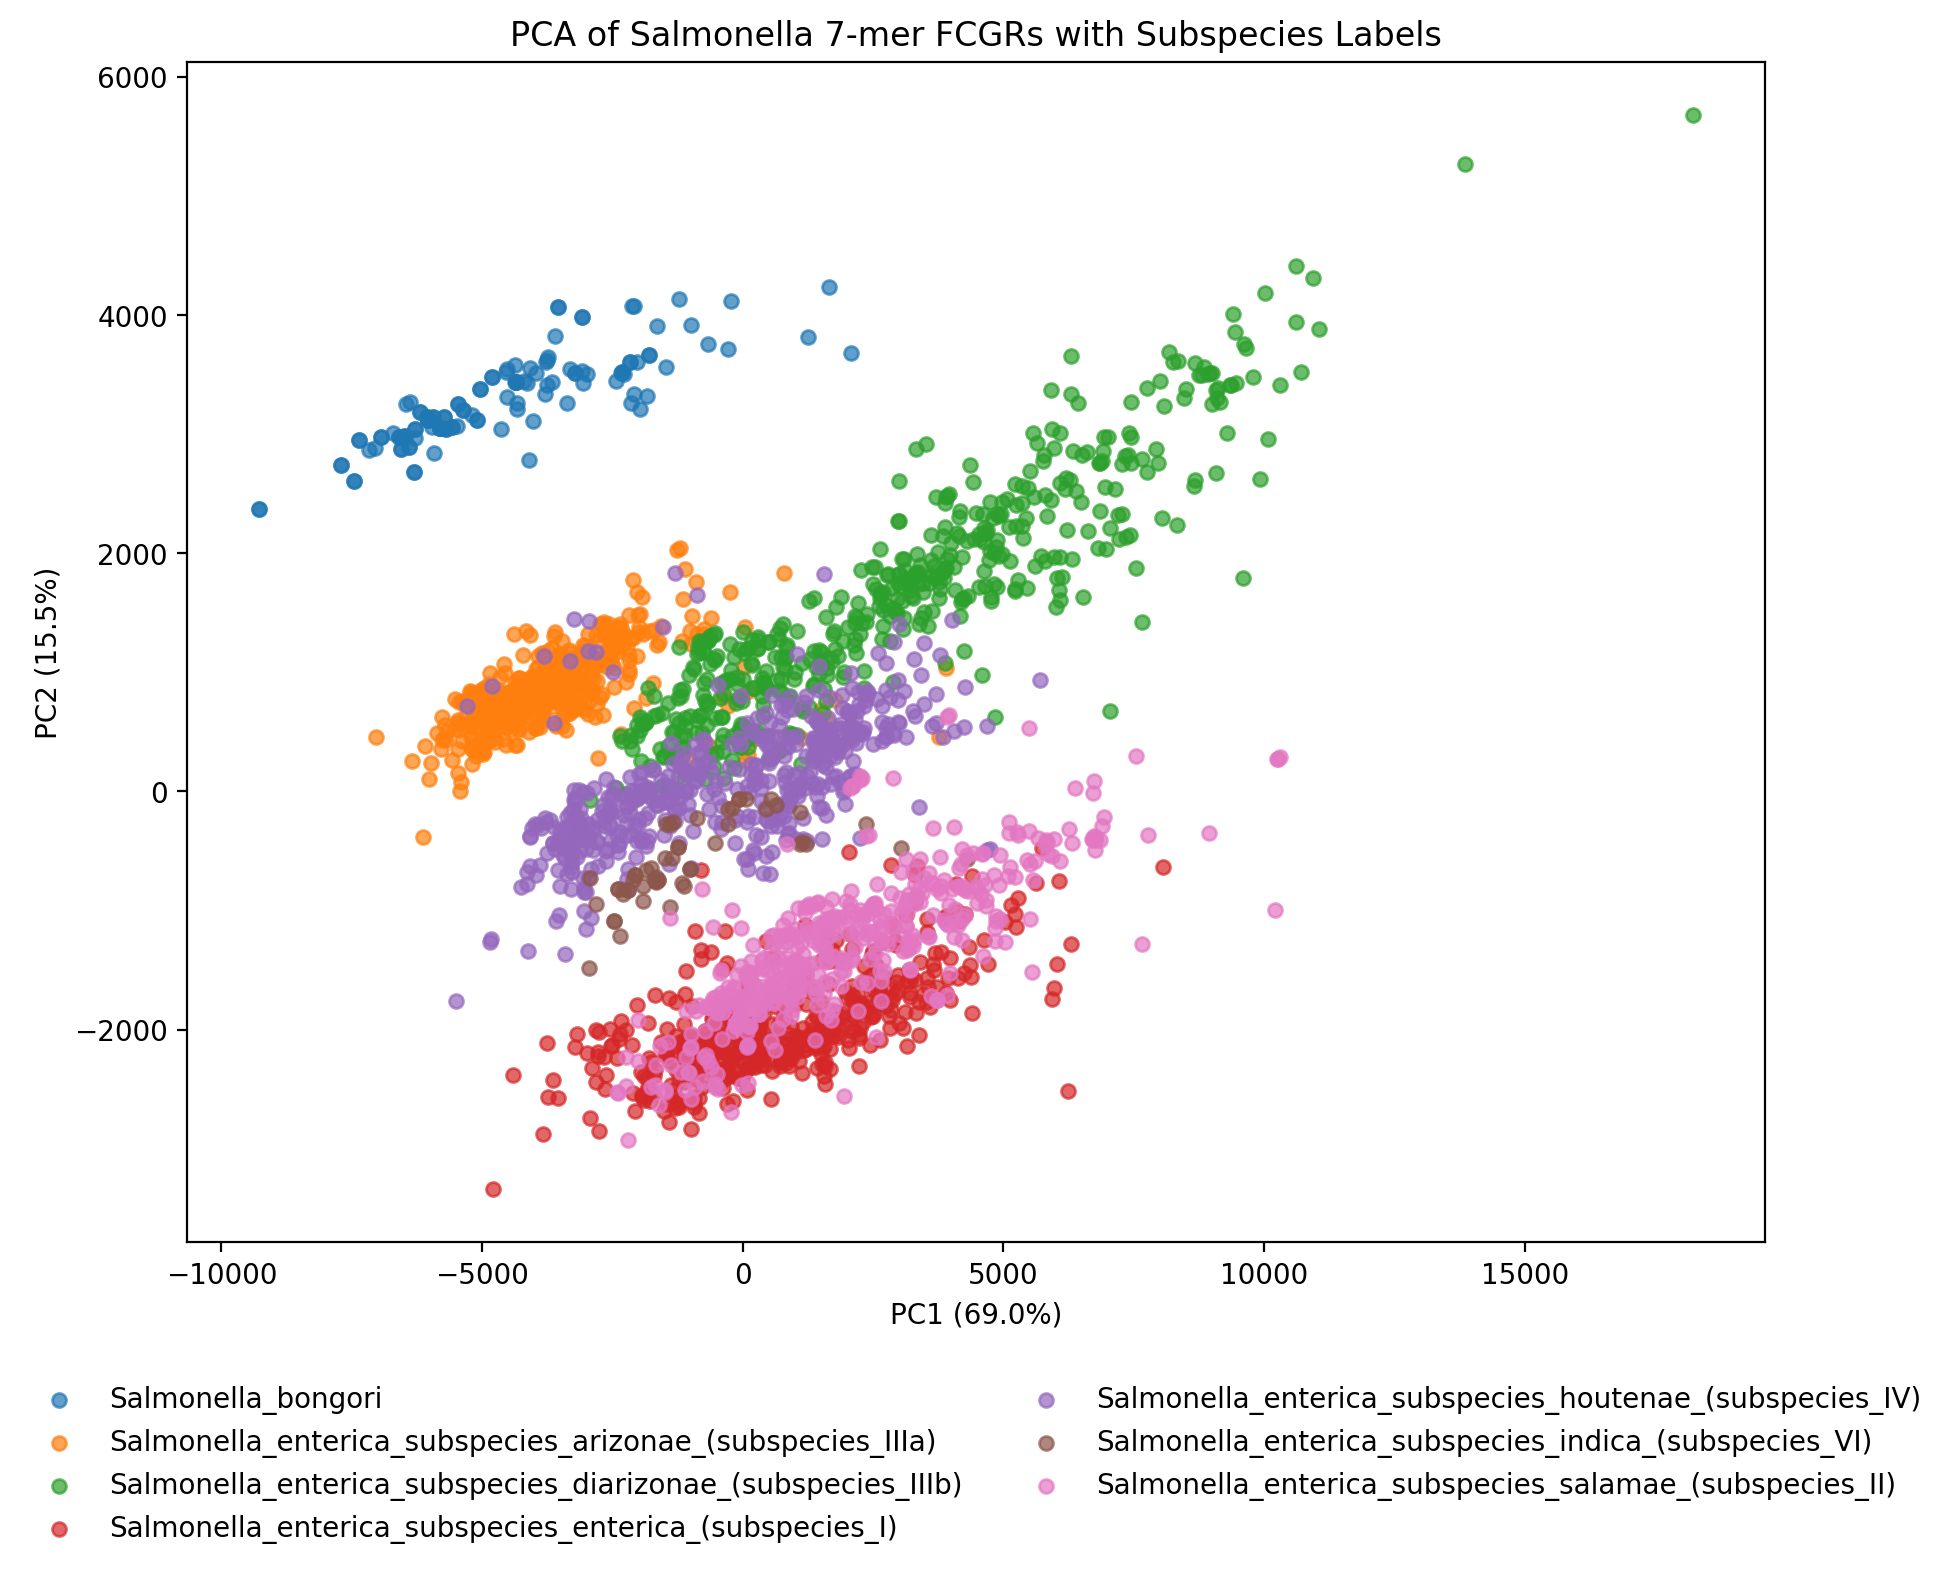

In [30]:
# Plot PCA
plt.figure(figsize=(10,8), dpi=200)

for subspecies in np.unique(y):
    mask = y == subspecies
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        label=subspecies,
        s=25,          # slightly smaller than default
        alpha=0.7
    )

plt.xlabel(f"PC1 ({explained_var[0]:.1f}%)")
plt.ylabel(f"PC2 ({explained_var[1]:.1f}%)")
plt.title("PCA of Salmonella 7-mer FCGRs with Subspecies Labels")

plt.legend(
    ncol=2,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    frameon=False
)

plt.tight_layout()
plt.savefig("salmonella_pca.png", dpi=300)
plt.show()
